In [7]:
import yfinance as yf
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
from VI_HMM import Encoder
import torch.nn.functional as F


In [149]:
C = 5
num_clusters = 3
hidden0 = 64
hidden1 = 64

In [164]:
end_day = 1000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

x_data = pd.read_csv('test_data.csv').drop(columns=['Date']).values[:end_day]

ckpt = torch.load('encoder_saved.pth', map_location='cpu')
enc_cfg = ckpt.get('config', {})
input_dim = enc_cfg.get('input_dim', C)
hidden_dim = enc_cfg.get('hidden_dim', hidden0)
hidden_dim2 = enc_cfg.get('hidden_dim2', hidden1)
K = enc_cfg.get('K', num_clusters)

# Recreate encoder architecture
encoder_loaded = Encoder(input_dim, hidden_dim, hidden_dim2, K)
encoder_loaded.load_state_dict(ckpt['model_state_dict'])
encoder_loaded.to(device)
encoder_loaded.eval()

x_tensor = torch.tensor(x_data, dtype=torch.float).permute(1, 0).unsqueeze(0)  # (1, C, T)
x_tensor = x_tensor.to(device)

encoder_loaded.to(device)
encoder_loaded.eval()
with torch.no_grad():
    logits = encoder_loaded(x_tensor)                 # (1, K, T)
    probs = F.softmax(logits, dim=1).squeeze(0).cpu().numpy()  # (K, T)
    regimes = np.argmax(probs, axis=0)                # (T,)

print('probs.shape (K, T):', probs.shape)
print('regimes.shape:', regimes.shape)  # should equal T_full

# align with SP500 history (example)
sp500 = yf.Ticker("^GSPC")
sp500_data = sp500.history(start="2020-01-01", end="2024-12-31")
prices = sp500_data['Close'].values[:end_day]

prices_aligned = prices[:len(regimes)]
index_aligned = sp500_data.index[:len(regimes)]

probs.shape (K, T): (3, 1000)
regimes.shape: (1000,)


C:\Users\hudso\AppData\Local\Temp\ipykernel_19960\4146915780.py:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap('Reds', K)


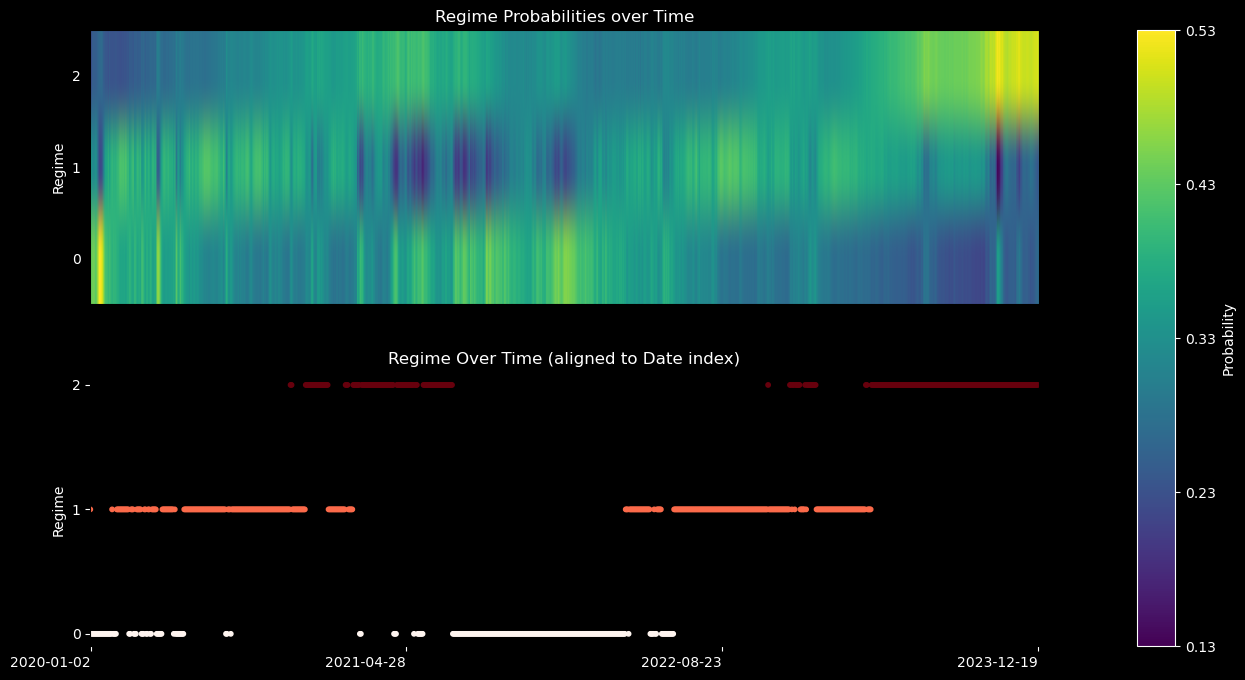

In [163]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
from matplotlib.dates import DateFormatter
import pandas as pd
start_date = 0
end_date = -1
probs_slice = probs[:, start_date:end_date]
regimes_slice = regimes[start_date:end_date]
index_aligned_slice = index_aligned[start_date:end_date]

K, T = probs_slice.shape[0], probs_slice.shape[1]

# choose a small number of x-ticks for readability
nticks = 4
tick_pos = np.linspace(0, T - 1, nticks, dtype=int)
tick_labels = [pd.to_datetime(index_aligned_slice[i]).strftime('%Y-%m-%d') for i in tick_pos]

# reserve narrow column for colorbar so heatmap and bottom plot share width
fig = plt.figure(figsize=(14, 8), facecolor='black')
gs = gridspec.GridSpec(2, 2, width_ratios=[1, 0.04], height_ratios=[1, 1],
                       wspace=0.2, hspace=0.25)

# heatmap: use extent so x-axis runs 0 to T and aligns with tick positions above
ax0 = fig.add_subplot(gs[0, 0], facecolor='black')
extent = [0, T, 0, K]
img = ax0.imshow(probs_slice, aspect='auto', cmap='viridis', origin='lower', extent=extent)
ax0.set_ylabel('Regime', color='white')
ax0.set_yticks(np.arange(K) + 0.5)
ax0.set_yticklabels(np.arange(K), color='white')
ax0.set_xticks(tick_pos + 0.5)
ax0.set_xticklabels(tick_labels)
ax0.set_title('Regime Probabilities over Time', color='white')

# colorbar for heatmap in reserved column
probs_range = np.linspace(probs_slice.min(), probs_slice.max(), 5)
colorbar_ax = fig.add_subplot(gs[:, 1])
cbar = plt.colorbar(img, cax=colorbar_ax, ticks=np.arange(K))
cbar.set_label('Probability', color='white')
cbar.ax.yaxis.label.set_color('white')
cbar.ax.tick_params(color='white')
cbar.outline.set_edgecolor('white')
cbar.set_ticks(probs_range)
cbar.ax.set_yticklabels([f'{t:.2f}' for t in probs_range], color='white')


# bottom plot: regimes and price
ax1 = fig.add_subplot(gs[1, 0], facecolor='black', sharex=ax0)
x_positions = np.arange(T)  # align points to heatmap column centers

# scatter regimes colored categorically
cmap = mpl.cm.get_cmap('Reds', K)
norm = mpl.colors.BoundaryNorm(np.arange(K+1), K)
ax1.scatter(x_positions, regimes_slice, c=regimes_slice, cmap=cmap, norm=norm, s=10)

ax1.set_ylabel('Regime', color='white')
ax1.set_yticks(np.arange(K))
ax1.set_yticklabels(np.arange(K), color='white')
ax1.set_xticks(tick_pos + 0.5)
ax1.set_xticklabels(tick_labels, ha='right', color='white')

ax1.set_title('Regime Over Time (aligned to Date index)', color='white')
ax1.tick_params(colors='white')
ax1.set_facecolor('black')

plt.show()

C:\Users\hudso\AppData\Local\Temp\ipykernel_19960\3360543178.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap('Reds', K)


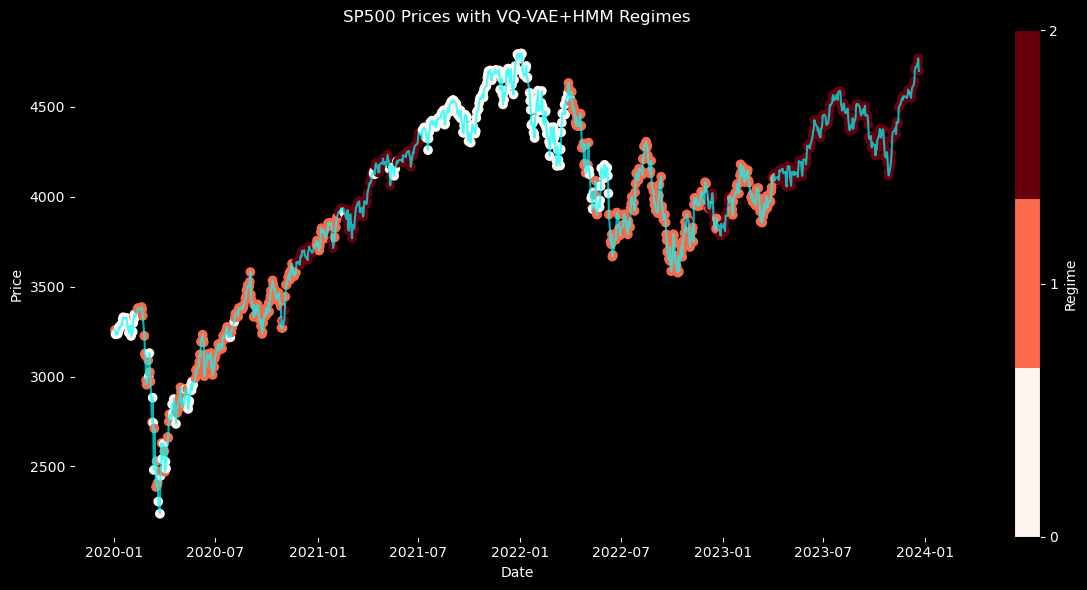

(array([0, 1, 2]), array([271, 407, 322]))

In [161]:
cmap = mpl.cm.get_cmap('Reds', K)   

# plot regimes against prices (align lengths)
fig, ax = plt.subplots(figsize=(12, 6), facecolor='black')
ax.plot(index_aligned, prices_aligned, color='cyan', label='SP500 Close Price', alpha=0.7)
scatter = ax.scatter(index_aligned, prices_aligned, c=regimes, cmap=cmap, label='Regimes')
ax.set_title('SP500 Prices with VQ-VAE+HMM Regimes', color='white')
ax.set_xlabel('Date', color='white')
ax.set_ylabel('Price', color='white')
ax.tick_params(colors='white')
cbar = plt.colorbar(scatter, ax=ax, ticks=np.arange(K))
cbar.set_label('Regime', color='white')
cbar.ax.set_yticklabels(np.arange(K), color='white')
cbar.ax.tick_params(color='white')
ax.set_facecolor('black')
plt.tight_layout()
plt.show()

np.unique(regimes, return_counts=True)